# Analysis of Hippocampal Responses to Odor Sequences

**⚠️ IMPORTANT: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results. Always validate the analyses and conclusions independently.**

This notebook demonstrates how to work with data from DANDI:001335, which contains Neuropixels recordings from the hippocampus of head-fixed mice during odor presentation experiments.

## Dataset Overview
- Subject: Adult male mouse (P8W)
- Recording: Neuropixels probe in dorsal CA1
- Task: Presentation of 6 different odors (A-F) in blocks
- Data types: Single unit spiking and LFP

## Experiment Structure
- Block 1: Odors A, B, C (Unexpected Events)
- Block 2: Odors D, E, F (Systematic Events)
- Block 3: Localizer

Each odor is presented 101 times throughout the experiment.

In [1]:
# Import required libraries
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data

First, we'll load the NWB file using lindi, which allows efficient remote access to the data.
We'll use the DANDI API URL to access the file.

In [2]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001335/assets/aca66db7-4c02-4453-8dcb-a179d44b1c5d/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic session information
print(f"Session ID: {nwb.identifier}")
print(f"Description: {nwb.session_description}")
print(f"Subject: {nwb.subject.subject_id} (Age: {nwb.subject.age})")
print(f"Keywords: {', '.join(nwb.keywords)}")

Session ID: M541-2024-08-31
Description: Block 1:UE (ABC), Block 2:SE (DEF), Block3:Localizer
Subject: M541 (Age: P8W/)
Keywords: ecephys, neuropixels, odor-sequences, hippocampus


## Analyzing Odor Presentation Timing

Let's examine when the different odors were presented. Note that odor presentations start 
after approximately 600 seconds into the recording.

We'll look at:
1. The timing of different blocks
2. Distribution of odor presentations within blocks
3. Inter-stimulus intervals

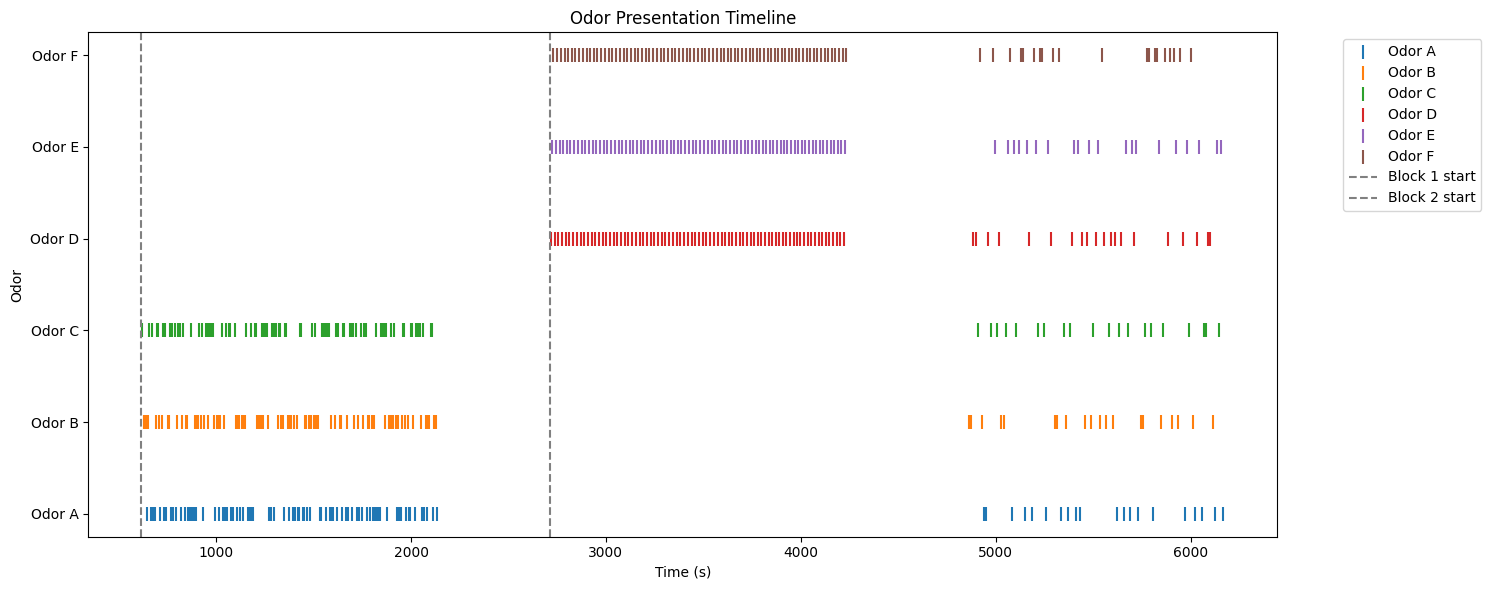

In [3]:
# Get block intervals
block1_start = nwb.intervals["Block 1"]["start_time"].data[:]
block1_stop = nwb.intervals["Block 1"]["stop_time"].data[:]
block2_start = nwb.intervals["Block 2"]["start_time"].data[:]
block2_stop = nwb.intervals["Block 2"]["stop_time"].data[:]

# Get odor presentation times
odors = ['A', 'B', 'C', 'D', 'E', 'F']
odor_times = {}
for odor in odors:
    starts = nwb.intervals[f"Odor {odor} ON"]["start_time"].data[:]
    stops = nwb.intervals[f"Odor {odor} ON"]["stop_time"].data[:]
    odor_times[odor] = {'start': starts, 'stop': stops}

# Create a raster plot of odor presentations
plt.figure(figsize=(15, 6))
for i, odor in enumerate(odors):
    plt.scatter(odor_times[odor]['start'], np.ones_like(odor_times[odor]['start']) * i,
               marker='|', s=100, label=f'Odor {odor}')

plt.axvline(block1_start, color='gray', linestyle='--', label='Block 1 start')
plt.axvline(block2_start, color='gray', linestyle='--', label='Block 2 start')
plt.ylabel('Odor')
plt.yticks(range(len(odors)), [f'Odor {o}' for o in odors])
plt.xlabel('Time (s)')
plt.title('Odor Presentation Timeline')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Neural Responses to Odors

Now we'll examine the neural responses to odor presentations. We'll:
1. Select a few example units
2. Create peristimulus time histograms (PSTHs) around odor onset
3. Compare responses to different odors

Note: We're only loading a small subset of units to keep computation time reasonable,
as the data is being streamed over the network.

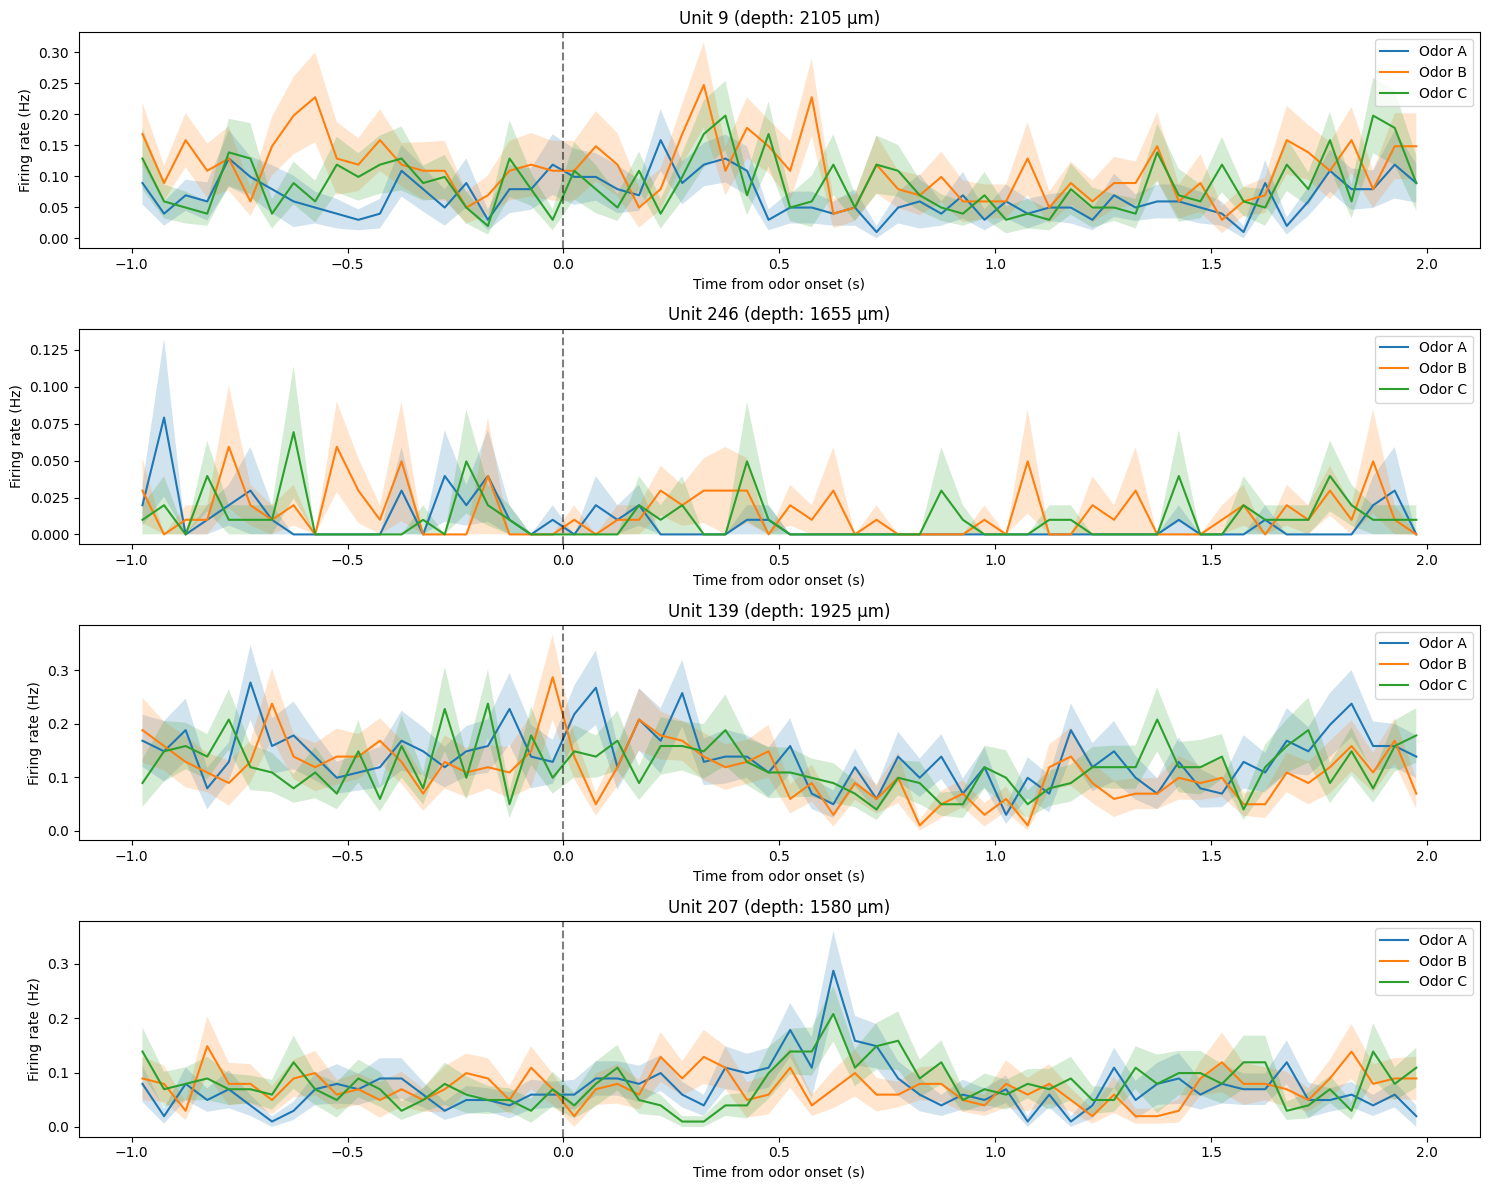

In [4]:
# Select 4 random units to analyze
np.random.seed(42)  # For reproducibility
n_units = 4
unit_indices = np.random.choice(len(nwb.units), n_units, replace=False)

# Function to create PSTH
def create_psth(spike_times, event_times, pre_time=1, post_time=2, bin_size=0.05):
    all_counts = []
    for event in event_times:
        mask = (spike_times >= event - pre_time) & (spike_times <= event + post_time)
        relative_times = spike_times[mask] - event
        counts, _ = np.histogram(relative_times, 
                               bins=np.arange(-pre_time, post_time + bin_size, bin_size))
        all_counts.append(counts)
    return np.mean(all_counts, axis=0), np.std(all_counts, axis=0) / np.sqrt(len(event_times))

# Create PSTH for each selected unit and each odor
plt.figure(figsize=(15, 3*n_units))
time_bins = np.arange(-1, 2 + 0.05, 0.05)
time_centers = (time_bins[:-1] + time_bins[1:]) / 2

for i, unit_idx in enumerate(unit_indices):
    plt.subplot(n_units, 1, i+1)
    
    # Get spike times for this unit
    spike_times = nwb.units['spike_times'][unit_idx]
    
    # Calculate PSTH for each odor
    for odor in ['A', 'B', 'C']:  # Using Block 1 odors
        psth, psth_err = create_psth(spike_times, odor_times[odor]['start'])
        plt.plot(time_centers, psth, label=f'Odor {odor}')
        plt.fill_between(time_centers, psth-psth_err, psth+psth_err, alpha=0.2)
    
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Time from odor onset (s)')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'Unit {unit_idx} (depth: {nwb.units["depth"][unit_idx]:.0f} μm)')
    plt.legend()

plt.tight_layout()

## LFP Analysis

Finally, let's look at the Local Field Potential (LFP) data around odor presentations.
We'll examine:
1. Raw LFP traces from different depths
2. LFP response to odor onset

Note: We're only loading a small time window of LFP data as the dataset is large
and streamed over the network.

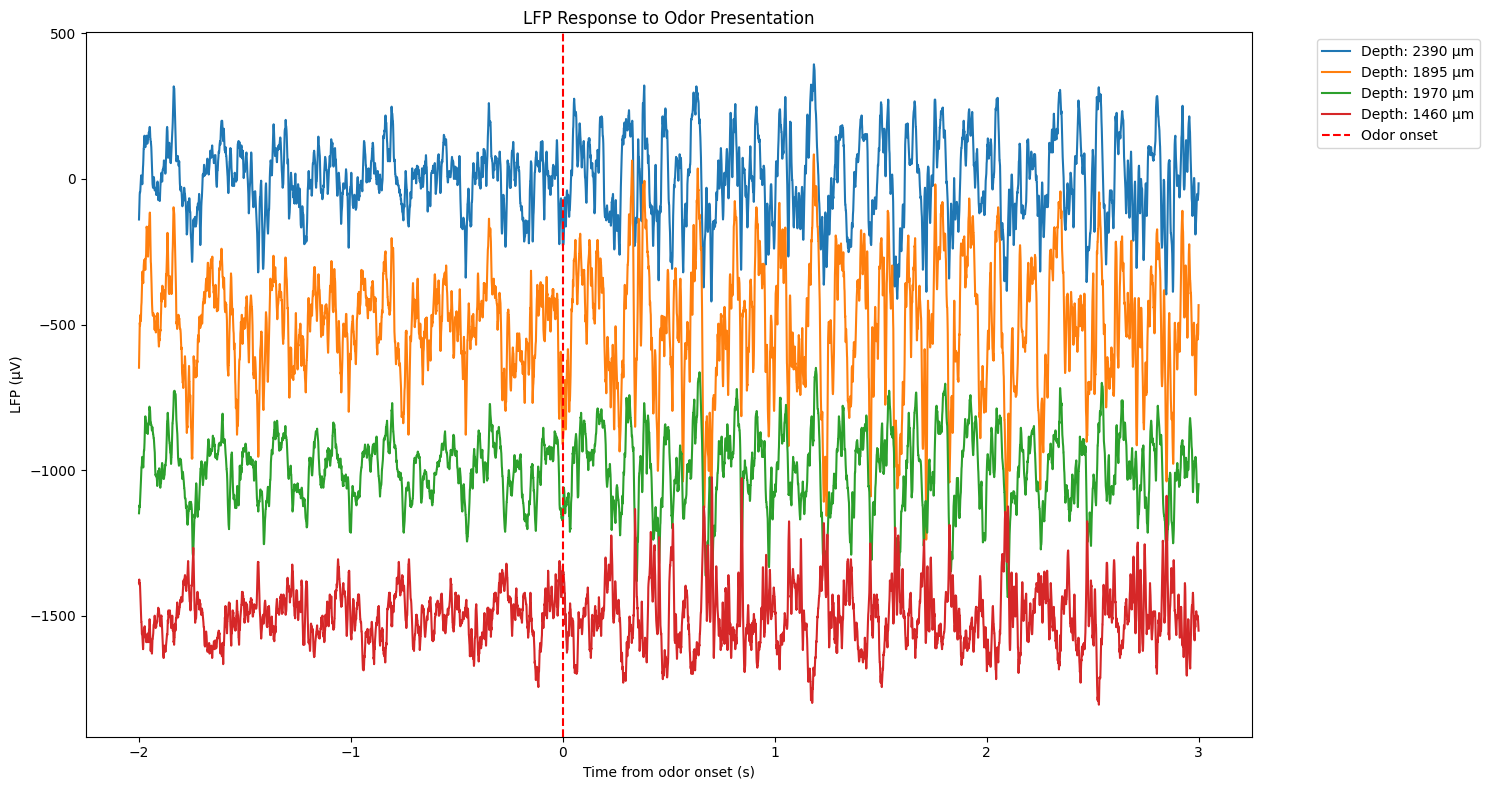

In [5]:
# Get LFP data around first presentation of Odor A
odor_start = odor_times['A']['start'][0]
window_size = 5  # seconds
pre_time = 2

# Calculate sample indices
sampling_rate = nwb.processing['ecephys']['LFP'].rate
start_idx = int((odor_start - pre_time) * sampling_rate)
n_samples = int(window_size * sampling_rate)

# Load LFP data for a subset of channels
channel_indices = np.linspace(0, 63, 4, dtype=int)  # 4 channels at different depths
lfp_data = nwb.processing['ecephys']['LFP'].data[start_idx:start_idx+n_samples, channel_indices]

# Get channel depths
channel_depths = nwb.ec_electrodes['depth'].data[channel_indices]

# Plot LFP traces
plt.figure(figsize=(15, 8))
time = np.arange(-pre_time, window_size-pre_time, 1/sampling_rate)
offset = 0
for i, (data, depth) in enumerate(zip(lfp_data.T, channel_depths)):
    plt.plot(time, data + offset, label=f'Depth: {depth:.0f} μm')
    offset -= 500  # Offset for visualization

plt.axvline(0, color='r', linestyle='--', label='Odor onset')
plt.xlabel('Time from odor onset (s)')
plt.ylabel('LFP (μV)')
plt.title('LFP Response to Odor Presentation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Example Research Questions

This dataset could be used to investigate several interesting scientific questions:

1. **Odor Encoding**: How do hippocampal neurons encode different odors? Are there cells
   that show selective responses to specific odors?

2. **Learning Effects**: Do neural responses to odors change between early and late
   presentations within a block? This could indicate learning or habituation.

3. **Population Dynamics**: How does the population of neurons collectively represent
   the odor information? Are there distinct population states for different odors?

4. **LFP-Spike Relationships**: Is there a relationship between LFP patterns and
   spike timing during odor presentation? This could reveal circuit-level mechanisms
   of odor processing.

To pursue these questions, you would need to:
- Analyze larger portions of the dataset
- Apply appropriate statistical tests
- Consider control analyses
- Compare results across multiple sessions/animals